# 模型的选择问题
##### 主要知识点为偏差和方差，训练集&验证集&测试集
需要先对一个水库的流出水量以及水库水位进行正则化线性归回，然后将会探讨方差-偏差的问题
##### 数据集：ex5data1.mat

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt

### 1.导入数据并展示

In [2]:
#导入数据
data = sio.loadmat('ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [3]:
#训练集
X_train,y_train = data['X'],data['y']
X_train.shape,y_train.shape
X_train

array([[-15.93675813],
       [-29.15297922],
       [ 36.18954863],
       [ 37.49218733],
       [-48.05882945],
       [ -8.94145794],
       [ 15.30779289],
       [-34.70626581],
       [  1.38915437],
       [-44.38375985],
       [  7.01350208],
       [ 22.76274892]])

In [4]:
#验证集
X_val,y_val = data['Xval'],data['yval']
X_val.shape,y_val.shape

((21, 1), (21, 1))

In [5]:
#测试集
X_test,y_test = data['Xtest'],data['ytest']
X_test.shape,y_test.shape

((21, 1), (21, 1))

In [6]:
X_train = np.insert(X_train,0,1,axis=1)
X_val = np.insert(X_val,0,1,axis=1)
X_test = np.insert(X_test,0,1,axis=1)
X_train

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

In [7]:
#数据展示
def plot_data():
    frg,ax = plt.subplots()
    ax.scatter(X_train[:,1],y_train)
    ax.set(xlabel='water_level',
          ylabel='flow')

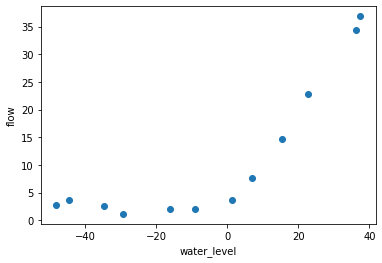

In [8]:
plot_data()

### 2.代价函数及梯度

In [9]:
#带正则化项的代价函数，lmd=0时就相当于没有正则化项
def reg_cost(theta,X,y,lmd):
    cost = np.sum(np.power(X@theta-y.flatten(),2))
    reg = theta[1:]@theta[1:]*lmd #第一项不用正则化因此去掉
    return (cost+reg)/(2*len(X))

In [10]:
theta = np.ones(X_train.shape[1]) #theta是二维的
lmd = 1
reg_cost(theta,X_train,y_train,lmd)

303.9931922202643

In [11]:
#正则化项代价函数的梯度
def reg_grad(theta,X,y,lmd):
    grad = (X@theta-y.flatten())@X
    reg = lmd * theta #此时theta的第一项在参与计算
    reg[0]=0 #把theta第一项取成0这样子相当于没有参与运算，又能使得维度不变方便后面的计算
    return (grad+reg) / (len(X))

In [12]:
reg_grad(theta,X_train,y_train,lmd)

array([-15.30301567, 598.25074417])

### 3.求解 

In [13]:
#使用工具库找到theta最优解
def train_model(X,y,lmd):
        theta = np.ones(X.shape[1])
        res = opt.minimize(fun = reg_cost,
                          x0 = theta,
                          args = (X,y,lmd),
                          method = 'TNC',
                          jac = reg_grad)
        return res.x

In [14]:
#令lmd=0，因为现在训练的是2维的，正则化不会对这种低维的有很大的帮助
theta_final = train_model(X_train,y_train,lmd=0)

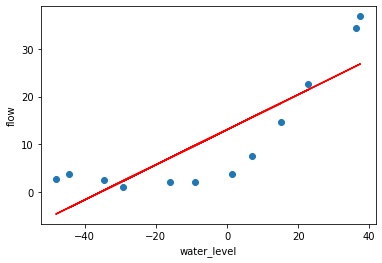

In [15]:
#画出此时拟合的图像
plot_data()
plt.plot(X_train[:,1],X_train@theta_final,c='r')
plt.show()

### 4.学习曲线 

In [16]:
def plot_learning_curve(X_train,y_train,X_val,y_val,lmd):
    x = range(1,len(X_train)+1)
    training_cost = []
    cv_cost = []
    
    for i in x:
        res_theta = train_model(X_train[:i,:],y_train[:i,:],lmd)#每次循环取出i个样本来计算求theta
        training_cost_i = reg_cost(res_theta,X_train[:i,:],y_train[:i,:],lmd)
        cv_cost_i = reg_cost(res_theta,X_val,y_val,lmd)
        training_cost.append(training_cost_i)
        cv_cost.append(cv_cost_i)
    
    plt.plot(x,training_cost,label = 'training cost')
    plt.plot(x,cv_cost,label = 'cv cost')
    plt.legend()
    plt.xlabel('number of example')
    plt.ylabel('error')
    plt.show()

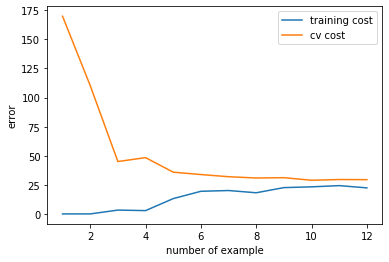

In [17]:
plot_learning_curve(X_train,y_train,X_val,y_val,lmd=0)

可以看出这个模型是高偏差的，表示欠拟合。
为了解决这个问题可以采用多项式特征

### 5.特征多项式及归一化 

In [18]:
#构造多项式特征
def poly_feature(X,power):
    for i in range(2,power+1):
        X = np.insert(X,X.shape[1],np.power(X[:,1],i),axis=1) #在X每一行后面添加该行值的i次方的数
    return X

In [19]:
#查看一下
poly_feature(X_train,6)

array([[ 1.00000000e+00, -1.59367581e+01,  2.53980260e+02,
        -4.04762197e+03,  6.45059724e+04, -1.02801608e+06,
         1.63832436e+07],
       [ 1.00000000e+00, -2.91529792e+01,  8.49896197e+02,
        -2.47770062e+04,  7.22323546e+05, -2.10578833e+07,
         6.13900035e+08],
       [ 1.00000000e+00,  3.61895486e+01,  1.30968343e+03,
         4.73968522e+04,  1.71527069e+06,  6.20748719e+07,
         2.24646160e+09],
       [ 1.00000000e+00,  3.74921873e+01,  1.40566411e+03,
         5.27014222e+04,  1.97589159e+06,  7.40804977e+07,
         2.77743990e+09],
       [ 1.00000000e+00, -4.80588295e+01,  2.30965109e+03,
        -1.10999128e+05,  5.33448815e+06, -2.56369256e+08,
         1.23208064e+10],
       [ 1.00000000e+00, -8.94145794e+00,  7.99496701e+01,
        -7.14866612e+02,  6.39194974e+03, -5.71533498e+04,
         5.11034273e+05],
       [ 1.00000000e+00,  1.53077929e+01,  2.34328523e+02,
         3.58705250e+03,  5.49098568e+04,  8.40548715e+05,
         1.2866945

In [20]:
#获取均值和方差来进行多项式归一化
def get_means_stds(X):
    means = np.mean(X,axis=0) #按照行的方向获得均值
    stds = np.std(X,axis=0)
    return means,stds

In [21]:
#归一化处理
def feature_normalize(X,means,stds):
    X[:,1:] = (X[:,1:] - means[1:])/stds[1:] 
    return X

In [22]:
#对训练集，验证集和测试集构造特征多项式
power = 8    #扩展特征到8
X_train_poly = poly_feature(X_train,power)
X_val_poly = poly_feature(X_val,power)
X_test_poly = poly_feature(X_test,power)

In [23]:
#获取训练集，验证集和测试集的方差和均值
X_train_means,X_train_stds = get_means_stds(X_train_poly)
X_val_means,X_val_stds = get_means_stds(X_val_poly)
X_test_means,X_test_stds = get_means_stds(X_test_poly)

In [24]:
#归一化训练集，验证集和测试集
X_train_norm = feature_normalize(X_train_poly,X_train_means,X_train_stds)
X_val_norm = feature_normalize(X_val_poly,X_val_means,X_val_stds)
X_test_norm = feature_normalize(X_test_poly,X_test_means,X_test_stds)

In [25]:
#计算归一化后的theta值，lmd这时取0表示不添加正则项
theta_fit = train_model(X_train_norm,y_train,lmd=0)

In [26]:
#画出此时拟合的图像
def plot_poly_fit():
    plot_data()
    
    x = np.linspace(-60,60,100)
    xx = x.reshape(100,1)
    xx = np.insert(xx,0,1,axis=1)
    xx = poly_feature(xx,power)
    xx_means,xx_stds = get_means_stds(xx)
    xx = feature_normalize(xx,xx_means,xx_stds)####
    
    plt.plot(x,xx@theta_fit,'r--')

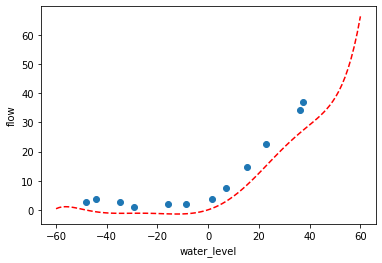

In [27]:
plot_poly_fit()

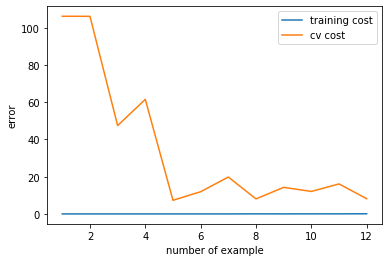

In [28]:
#此时的学习曲线
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lmd=0)

训练代价太低，过拟合了。可以改变正则化项来调整

### 6.调整正则化系数$\lambda$ 的值

#### $\lambda = 1$ 

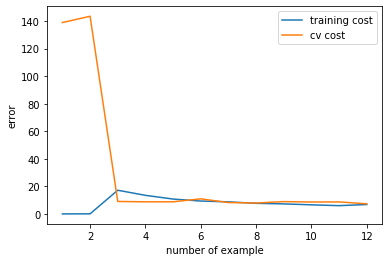

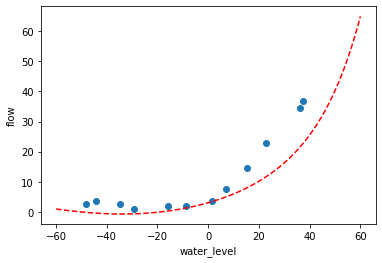

In [29]:
lmd = 1
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lmd)
theta_fit = train_model(X_train_norm,y_train,lmd)
plot_poly_fit()

 训练代价不再是0了，也就是说我们减轻**过拟合**

#### $\lambda = 100$ 

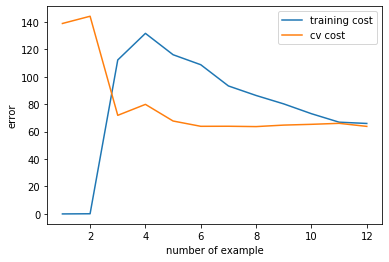

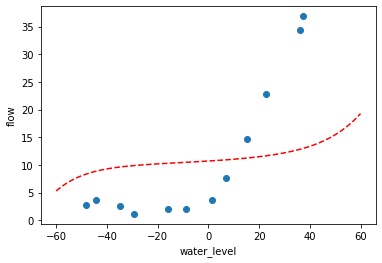

In [30]:
lmd = 100
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lmd)
theta_fit = train_model(X_train_norm,y_train,lmd)
plot_poly_fit()

太多正则化惩罚太多，变成 **欠拟合**状态

### 7.选取合适的$\lambda$的值 

In [31]:
lmds = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]
training_cost = []
cv_cost = []

for lmd in lmds:
    res = train_model(X_train_norm,y_train,lmd)
    tc = reg_cost(res,X_train_norm,y_train,lmd=0)
    cv = reg_cost(res,X_val_norm,y_val,lmd=0)
    training_cost.append(tc)
    cv_cost.append(cv)

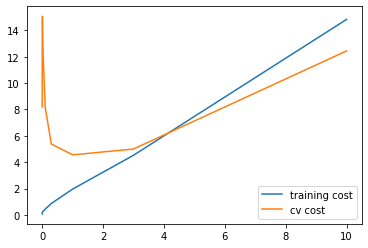

In [32]:
plt.plot(lmds,training_cost,label='training cost')
plt.plot(lmds,cv_cost,label='cv cost')
plt.legend()
plt.show()

In [33]:
#此时对应test集的代价
for i in lmds:
    res = train_model(X_train_norm,y_train,lmd=i)
    test_cost = reg_cost(res,X_test_norm,y_test,lmd=0)    
    print('test cost(lmd={}) = {}'.format(i, test_cost))

test cost(lmd=0) = 11.045388758597117
test cost(lmd=0.001) = 11.11317506836481
test cost(lmd=0.003) = 11.312251841569386
test cost(lmd=0.01) = 10.987793358695388
test cost(lmd=0.03) = 10.218965289969265
test cost(lmd=0.1) = 8.95392653501103
test cost(lmd=0.3) = 7.7451853754550015
test cost(lmd=1) = 7.851562250636016
test cost(lmd=3) = 11.770308905064539
test cost(lmd=10) = 26.894076369178887


可以看到当**lmd=0.3**时test cost最小，这是最优解了。